In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys

sys.path.insert(0, '/nfs/privileged/isalazar/projects/ultrasound-image-formation/')
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from exploration.EMBC2024.cross_experiment.train import load_model as load_nair_model
from exploration.advtraining.ifsr001_nair_advTrain import load_model as load_nairAdv_model
from strohm_train import load_model as load_strohm_model
from wang_train import load_wang_model
from src.US_data import LoadData_phantomLIM_ATSmodel539, LoadDataPICMUS
from src.beamforming_utils import make_pixel_grid_from_pos
from utils import downsample_channel_data, compute_metrics
from src.beamforming_DAS import make_bimg_das1
from pytorch_msssim import MS_SSIM
from skimage.restoration import denoise_nl_means
import cv2
from src.US_data import PlaneWaveData
import h5py
from scipy.signal import hilbert
import numpy as np
from skimage import measure, morphology
from scipy import ndimage


In [2]:
class ShapeVariationDataLoader(PlaneWaveData):
    def __init__(self, h5_dir, h5_name, simu_name):
        h5filename = os.path.join(h5_dir, h5_name)
        print(h5filename)
        with h5py.File(h5filename, "r") as g:
            print(g.keys())
            f = g[simu_name]
            self.idata = np.expand_dims(np.array(f["signal"], dtype="float32"), 0)
            self.qdata = np.imag(hilbert(self.idata, axis=-1))
            self.angles = np.array([0])
            self.fc = np.array(f['fc']).item()
            self.fs = np.array(f['fs']).item()
            self.c = np.array(f['c']).item()
            self.time_zero = np.array([np.array(f['time_zero']).item()])
            self.phantom_xlims = [-0.02, 0.02]
            self.phantom_zlims = [0.03, 0.08]
            self.grid_xlims = [-0.02, 0.02]
            self.grid_zlims = [0.03, 0.08]
            self.fdemod = 0
            xs = np.squeeze(np.array(f['ele_pos']))
            self.ele_pos = np.array([xs, np.zeros_like(xs), np.zeros_like(xs)]).T
            # self.pos_lat = np.array(f['lat_pos']).item()
            # self.pos_ax = np.array(f['ax_pos']).item()
        super().validate()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
this_dir = 'C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/'
basic_dataset_dir = 'C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/sample_data/'
h5_dataset_dir = f'{basic_dataset_dir}/naturalPerturbations/shape/v1.0'

# load model
epoch = 99
das_label = 'DAS'
# wang_label = 'wang_adv_eps0.008'
model_nair, _ = load_nair_model(model_dir=os.path.join(this_dir, "models", 'nair'),
                                epoch=epoch,
                                device=device)
model_strohm, _ = load_strohm_model(model_dir=os.path.join(this_dir, "models", 'strohm'),
                                    epoch=epoch,
                                    device=device)
model_wang, _, _, _, _ = load_wang_model(model_dir=os.path.join(this_dir, "models", 'wang'),
                                         epoch=epoch,
                                         num_downs=5,
                                         device=device)
model_nair.eval()
model_strohm.eval()
model_wang.eval()
print("")

Loading model 99...
Model 99 loaded.
Loading model 99...
Model 99 loaded.
Loading models 99...
Generator 99 loaded.
Discriminator 99 loaded.


In [4]:
inclusion_shape = 'square'
simu_name = 'simu00006'

h5name = "inclusion_%s.h5" % inclusion_shape
P = ShapeVariationDataLoader(h5_dir=h5_dataset_dir, h5_name=h5name, simu_name=simu_name)
max_value = np.max(np.abs(np.array([P.idata, P.qdata])))
P.idata = P.idata / max_value
P.qdata = P.qdata / max_value
# ------ Create grid
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[-1], 128)
depths = np.linspace(P.grid_zlims[0], P.grid_zlims[-1], 800)
grid_full = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)

# channel_data_shape, depth_samples, offset = downsample_channel_data(copy.deepcopy(P),
#                                                                     nsamples=800,
#                                                                     device=device)
channel_data_shape = downsample_channel_data(copy.deepcopy(P),
                                             laterals=laterals,
                                             depths=depths,
                                             device=device)
channel_data_shape = channel_data_shape / channel_data_shape.abs().max()

extent_full = [P.grid_xlims[0] * 1e3, P.grid_xlims[-1] * 1e3,
               P.grid_zlims[-1] * 1e3, P.grid_zlims[0] * 1e3]
opts = {"extent": extent_full, "origin": "upper"}

# ------ DAS and models' reconstructions
# ------------------------------------------------------------------------------
das_phantom, _ = make_bimg_das1(copy.deepcopy(P), grid_full, device=device)
# ------------------------------------------------------------------------------
nair_phantom = model_nair(channel_data_shape)
# ------------------------------------------------------------------------------
strohm_phantom = model_strohm(channel_data_shape)
# ------------------------------------------------------------------------------
N, C, H, W = channel_data_shape.size()
z = torch.randn(N, 1, H, W).to(device)
wang_phantom = model_wang(torch.cat((channel_data_shape, z), dim=1))
# ------------------------------------------------------------------------------

output_in_bmode_format = lambda x: (x * 60 - 60).detach().cpu().numpy().squeeze()

nair_phantom = output_in_bmode_format(nair_phantom)
strohm_phantom = output_in_bmode_format(strohm_phantom)
wang_phantom = output_in_bmode_format(wang_phantom)

bmodes = {'DAS': das_phantom, 'NAIR': nair_phantom, 'STROHM': strohm_phantom, 'WANG': wang_phantom}

C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/sample_data//naturalPerturbations/shape/v1.0\inclusion_square.h5
<KeysViewHDF5 ['simu00001', 'simu00002', 'simu00003', 'simu00004', 'simu00005', 'simu00006', 'simu00007', 'simu00008']>


In [5]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def create_square_mask(grid_full, vertices):
    # Create an empty mask
    square_mask = np.zeros(grid_full.shape[:2], dtype=bool)

    # Define vertices of the square
    v1, v2, v3, v4 = vertices

    # Iterate over each pixel in the grid
    for i in range(grid_full.shape[0]):
        for j in range(grid_full.shape[1]):
            x = grid_full[i, j, 0]
            z = grid_full[i, j, 2]

            # Check if the pixel is inside the square
            if (v1[0] <= x <= v2[0] or v2[0] <= x <= v1[0]) and \
               (v1[1] <= z <= v4[1] or v4[1] <= z <= v1[1]):
                square_mask[i, j] = True

    return square_mask

def calculate_square_vertices(center, side_length):
    x_center, z_center = center
    half_side_length = side_length / 2

    # Calculate vertices
    v1 = (x_center - half_side_length, z_center + half_side_length)
    v2 = (x_center + half_side_length, z_center + half_side_length)
    v3 = (x_center + half_side_length, z_center - half_side_length)
    v4 = (x_center - half_side_length, z_center - half_side_length)

    return v1, v2, v3, v4

In [6]:
center = (0.0, 55/1000)
# Define side length of the square
side_length = 12/1000

# Calculate vertices of the square
vertices = calculate_square_vertices(center, side_length)
roi_ref = create_square_mask(grid_full, vertices)

Text(0.5, 0.98, 'inclusion_square.h5')

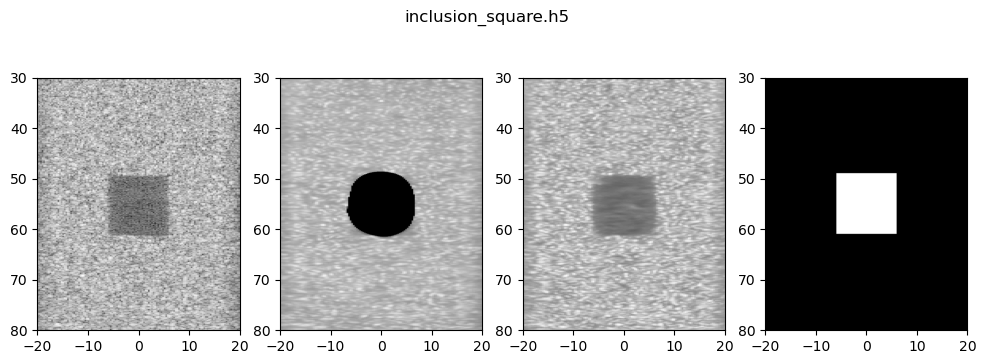

In [7]:
ncols = len(bmodes)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(3 * ncols, 4))
for counter, name in enumerate(bmodes):
    ax[counter].imshow(bmodes[name], cmap="gray", vmin=-60, vmax=0, **opts)
ax[-1].imshow(roi_ref, cmap="gray", vmin=0, vmax=1, **opts)
plt.suptitle('%s' % h5name)

In [8]:
# Initialize lists to store parameters and iou values
h_values = []
patch_size_values = []
patch_distance_values = []
threshold_values = []
name_values = []
iou_values = []

# Define parameter ranges
h_range = np.linspace(0.01, 0.21, 11)
patch_size_range = np.linspace(3, 15, 7)
patch_distance_range = np.linspace(3, 21, 10)
threshold_range = np.linspace(0.4, 0.7, 31)

# Iterate over parameter combinations
counter = 0
for h in h_range:
    for patch_size in patch_size_range:
        for patch_distance in patch_distance_range:
            for name in bmodes:
                bmode = bmodes[name]
                bmode_img = (bmode + 60) / 60
                smooth = denoise_nl_means(bmode_img,
                                            h=h,
                                            patch_size=int(patch_size),
                                            patch_distance=int(patch_distance),
                                            # sigma=sigma,
                                            preserve_range=True)
                print(f"({counter}/{11*7*10*4}) - hsname: {h5name}, h: {h}, patch_size: {patch_size}, patch_distance: {patch_distance}, bmf: {name}", end='')
                counter += 1
                for threshold in threshold_range:
                    print(".", end='')
                    mask = smooth<threshold
                    
                    labeled_mask, num_labels = measure.label(mask, connectivity=2, return_num=True)

                    if num_labels > 0:
                        largest_object_label = np.argmax(np.bincount(labeled_mask.flat)[1:]) + 1
                        largest_object_mask = (labeled_mask == largest_object_label)
                        filled_mask = ndimage.binary_fill_holes(largest_object_mask)
                    
                        iou = calculate_iou(roi_ref, filled_mask)
                    
                        # Append parameter values and iou to lists
                        h_values.append(h)
                        patch_size_values.append(patch_size)
                        patch_distance_values.append(patch_distance)
                        threshold_values.append(threshold)
                        name_values.append(name)
                        iou_values.append(iou)
                    else:
                        print("No labeled regions found in the mask.")
                    # largest_object_label = np.argmax(np.bincount(labeled_mask.flat)[1:]) + 1
                    # largest_object_mask = (labeled_mask == largest_object_label)
                    # filled_mask = ndimage.binary_fill_holes(largest_object_mask)
                    # 
                    # iou = calculate_iou(roi_ref, filled_mask)
                    
                    # # Append parameter values and iou to lists
                    # h_values.append(h)
                    # patch_size_values.append(patch_size)
                    # patch_distance_values.append(patch_distance)
                    # threshold_values.append(threshold)
                    # name_values.append(name)
                    # iou_values.append(iou)
                print(" ")

# Create DataFrame
data = {
    'h': h_values,
    'patch_size': patch_size_values,
    'patch_distance': patch_distance_values,
    'threshold': threshold_values,
    'name': name_values,
    'iou': iou_values
}

df = pd.DataFrame(data)
df.to_csv(f'grid_search_{h5name[:-4]}.csv', index=False)  # Set index=False to exclude row numbers


(0/3080) - hsname: inclusion_square.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, bmf: DAS............................... 
(1/3080) - hsname: inclusion_square.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, bmf: NAIR............................... 
(2/3080) - hsname: inclusion_square.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, bmf: STROHM............................... 
(3/3080) - hsname: inclusion_square.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, bmf: WANG............................... 
(4/3080) - hsname: inclusion_square.h5, h: 0.01, patch_size: 3.0, patch_distance: 5.0, bmf: DAS............................... 
(5/3080) - hsname: inclusion_square.h5, h: 0.01, patch_size: 3.0, patch_distance: 5.0, bmf: NAIR............................... 
(6/3080) - hsname: inclusion_square.h5, h: 0.01, patch_size: 3.0, patch_distance: 5.0, bmf: STROHM............................... 
(7/3080) - hsname: inclusion_square.h5, h: 0.01, patch_size: 3.0, patch_distance: 5.0, bmf: WAN

In [9]:
df[df['iou'] == df['iou'].max()]

,h,patch_size,patch_distance,threshold,name,iou
33628,0.07,15.0,13.0,0.59,DAS,0.915554


In [10]:
df.groupby('name')['iou'].max()


name
DAS       0.915554
NAIR      0.876954
STROHM    0.894281
WANG      0.895759
Name: iou, dtype: float64

In [11]:
max_iou_index = df.groupby('name')['iou'].idxmax()
result_df = df.loc[max_iou_index]
result_df

,h,patch_size,patch_distance,threshold,name,iou
33628,0.07,15.0,13.0,0.59,DAS,0.915554
29058,0.07,7.0,17.0,0.63,NAIR,0.876954
32231,0.07,13.0,9.0,0.57,STROHM,0.894281
88620,0.21,9.0,15.0,0.57,WANG,0.895759


In [12]:
result_df['dice'] = 2*result_df['iou']/(1+result_df['iou'])
result_df

,h,patch_size,patch_distance,threshold,name,iou,dice
33628,0.07,15.0,13.0,0.59,DAS,0.915554,0.955916
29058,0.07,7.0,17.0,0.63,NAIR,0.876954,0.934444
32231,0.07,13.0,9.0,0.57,STROHM,0.894281,0.944191
88620,0.21,9.0,15.0,0.57,WANG,0.895759,0.945014
